In [2]:
import sys
sys.path.append('../')

# from qiskit_ibm_runtime import QiskitRuntimeService
from investigation_functions import circuit_funcs, data_extract_funcs
# import config

from investigation_functions import  meta_dataframe_functions as mdf
import config
# import backend_vars

from qiskit_ibm_runtime.fake_provider import  FakeTorino, FakeBrisbane
from qiskit_ibm_runtime.fake_provider import FakeFez, FakeMarrakesh

from qiskit import transpile

from csv import DictWriter
import pandas as pd


In [3]:

nr_qubits = 4
qc_set = circuit_funcs.make_set_of_3(nr_qubits)

In [4]:
sim_backend = FakeBrisbane()
    # Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuits = transpile(qc_set, backend =sim_backend, optimization_level =0)

In [5]:
print(transpiled_circuits[2].depth())
print(transpiled_circuits[2].width())
print(transpiled_circuits[2].size())
print(transpiled_circuits[2].count_ops())

115
131
226
OrderedDict({'rz': 130, 'sx': 74, 'ecr': 18, 'measure': 4, 'barrier': 1})


In [6]:
def save_transpiled_metrics(nr_qubits,fake_backends,file_name,dirr):
    qc_set = circuit_funcs.make_set_of_3(nr_qubits)
    for backend in fake_backends:
        # print(backend.name)
        transpiled_circuits = transpile(qc_set, backend =backend, optimization_level =0)
        for circ in range(3):
            # print("circ:"+str(circ))
            depth = transpiled_circuits[circ].depth()
            size = transpiled_circuits[circ].size()
            width = transpiled_circuits[circ].width()
            # n_ops = transpiled_circuits[circ].count_ops()
            row = {
                'nr_qubits': nr_qubits,
                'backend': backend.name,
                'circuit': circ+1,
                'depth': depth,
                'size': size,
                'width': width,
                
            } #| n_ops
            fields = ['nr_qubits','backend','circuit','depth','size',
                      'width']#,'rz','ecr', 'barrier', 'x', 'measure',
                        # 'sx','cz']
            
            with open(dirr+file_name, 'a', newline='') as f:
                writer = DictWriter(f, fieldnames=fields)
                writer.writerow(row)

def create_transpiled_metrics_csv(file_name,dirr):
    fields = ['nr_qubits','backend','circuit','depth','size','width']
            #   ,'rz','ecr', 'barrier', 'x', 'measure', 'sx','cz']
    with open(dirr+file_name, 'w', newline='') as f:
        writer = DictWriter(f, fieldnames=fields)
        writer.writeheader()

def save_pretranspiled_metrics(nr_qubits,file_name,dirr):
    qc_set = circuit_funcs.make_set_of_3(nr_qubits)
    for circ in range(3):
        # print("circ:"+str(circ))
        depth = qc_set[circ].depth()
        size = qc_set[circ].size()
        width = qc_set[circ].width()
     
        row = {
            'nr_qubits': nr_qubits,
            'backend': 'pre-transpilation',
            'circuit': circ+1,
            'depth': depth,
            'size': size,
            'width': width,
            
        } #| n_ops
        fields = ['nr_qubits','backend','circuit','depth','size',
                'width']#,'rz','ecr', 'barrier', 'x', 'measure',
                # 'sx','cz']#,'cx','h','swap']

        with open(dirr+file_name, 'a', newline='') as f:
            writer = DictWriter(f, fieldnames=fields)
            writer.writerow(row)

In [7]:
fake_backends = [FakeBrisbane(), FakeTorino(), FakeFez(), FakeMarrakesh()]
dirr = '../Transpiled_circuits/'
file_name = 'transpiled_metrics_4qubits.csv'

In [8]:
# for nq in [4,8,16]:
#     file_name_ = file_name.replace('4',str(nq))
#     create_transpiled_metrics_csv(file_name_,dirr)
#     save_transpiled_metrics(nq,fake_backends,file_name_,dirr)
#     save_pretranspiled_metrics(nq,file_name_,dirr)

In [9]:
df_4q = pd.read_csv('../Transpiled_circuits/transpiled_metrics_4qubits.csv')
df_8q = pd.read_csv('../Transpiled_circuits/transpiled_metrics_8qubits.csv')
df_16q = pd.read_csv('../Transpiled_circuits/transpiled_metrics_16qubits.csv')

df_all = pd.concat([df_4q,df_8q,df_16q])

In [10]:
df_allm = df_all.melt(id_vars=['nr_qubits','backend','circuit'], 
                      value_vars=['depth','size','width'],
                      var_name ='metrics',
                      value_name='vals')

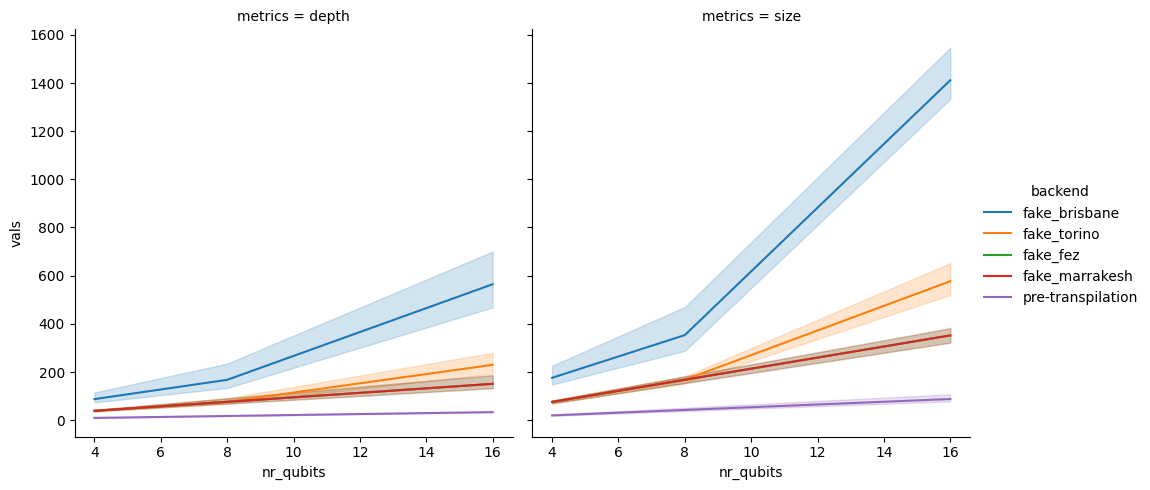

In [11]:
import seaborn as sns

sns.relplot(
    data=df_allm[df_allm['metrics'].isin(['depth','size'])],
    x='nr_qubits', 
    y='vals', 
    hue='backend', 
    col = 'metrics',
    kind='line'
)

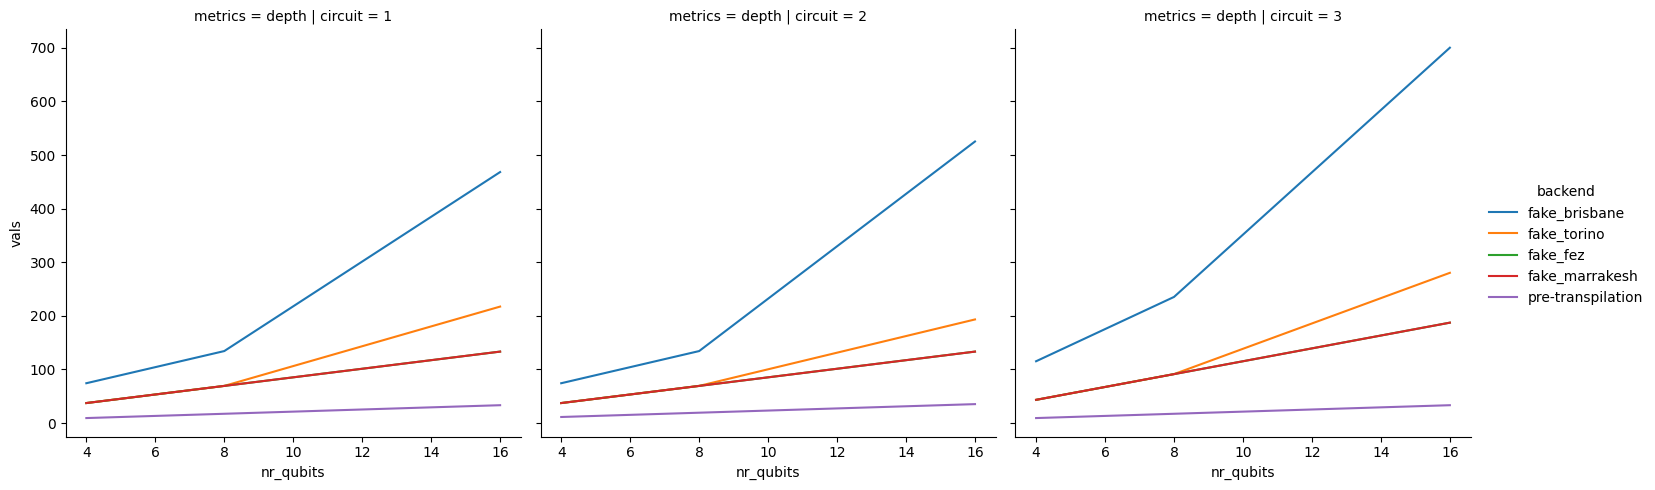

In [12]:
sns.relplot(
    data=df_allm[df_allm['metrics'].isin(['depth'])],
    x='nr_qubits', 
    y='vals', 
    hue='backend', 
    row = 'metrics',
    col = 'circuit',
    kind='line'
)

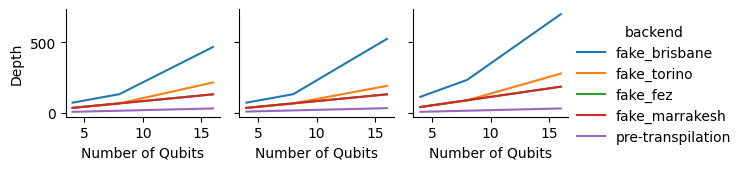

In [13]:
grid =sns.relplot(
    data=df_allm[df_allm['metrics'].isin(['depth'])],
    x='nr_qubits', 
    y='vals', 
    hue='backend', 
    row = 'metrics',
    col = 'circuit',
    kind='line',
    height = 2,
    aspect =1,
    # legend = {title ="Backends",
    #  label_order=["Brisbane","Torino","Fez","Marrakesh"]}
   
)
grid.set_ylabels('Depth')
grid.set_xlabels('Number of Qubits')
grid.set_titles( '')
# grid.add_legend(
#      title ="Backends",
#      label_order=["Brisbane","Torino","Fez","Marrakesh"]
# )


In [129]:
import matplotlib.pyplot as plt
def make_line_plots( 
        df,
        x= 'nr_qubits',
        y = 'corr avg',
        hue = 'circuits',
        col='backends',
        title_ = None,
        fig_size_ = (12,2),
        x_label = 'Number of Qubits',
        y_label = None,
        y_lim = None,
        share_y = True,
        share_y_ticks = True,
        grid = True,
        axis_font_size = 15,
        col_titles = None,
        legend_title = None,
        legend_labels = None,
        legend_fontsize = 14,
        vertical_stack = False,
        x_ticks_auto = False
    ):
    if y_label ==None:
        y_label = y
        
    cols = df[col].unique()
    num_cols = len(cols)
    num_rows =1
    if vertical_stack:
        num_cols = 1
        num_rows =len(cols)
    
    axs =[]
    if col_titles == None:
        col_titles = cols
    if legend_title == None:
        legend_title = hue
    
    fig = plt.figure(layout = 'constrained',figsize=fig_size_)
    # fig = plt.figure(figsize=fig_size_)
    fig.suptitle(title_, fontsize=16, fontweight='bold')
    for i in range(max(num_cols,num_rows)):
        if share_y and i>0:
            y_ax = axs[0]
            
        else:
            y_ax = None
        plt.subplot(num_rows,num_cols,i+1, sharey = y_ax,label = str(i))
        axs.append(
            sns.lineplot(
                data = df[df[col]==cols[i]],
                x= x,
                y = y,
                hue = hue
            )
        )
        axs[i].get_legend().remove()
        axs[i].set_title(col_titles[i], fontsize = axis_font_size+1)
        axs[i].set_ylabel(y_label, fontsize = axis_font_size)
        axs[i].set_xlabel(x_label, fontsize = axis_font_size)
        if not x_ticks_auto:
            axs[i].set_xticks([4,8,16])
        axs[i].tick_params(
            axis='both', which='both', labelsize=axis_font_size)
        axs[i].set_ylim(y_lim)
        if grid:
            axs[i].grid(visible =grid, linestyle ='dotted')   
    
    if share_y:
        for ax in axs[1:]:
            ax.set_ylabel('')
            # ax.set_yticks
   
    if share_y_ticks:
            for ax in axs:
                ax.label_outer()
 
    axs[1].legend(
        # handles =axs[0],
        title = legend_title,
        labels = legend_labels,
        title_fontsize = legend_fontsize+1,
        fontsize = legend_fontsize,
        # loc='center left', 
        # bbox_to_anchor=(1.05, 0.5), borderaxespad=0.
        loc='lower center', bbox_to_anchor=(0.5, -0.1),
        borderaxespad=10,
        ncol =3
        )
    return axs

c:\Users\epste\anaconda3\envs\qiskE\Lib\site-packages\IPython\core\events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
c:\Users\epste\anaconda3\envs\qiskE\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


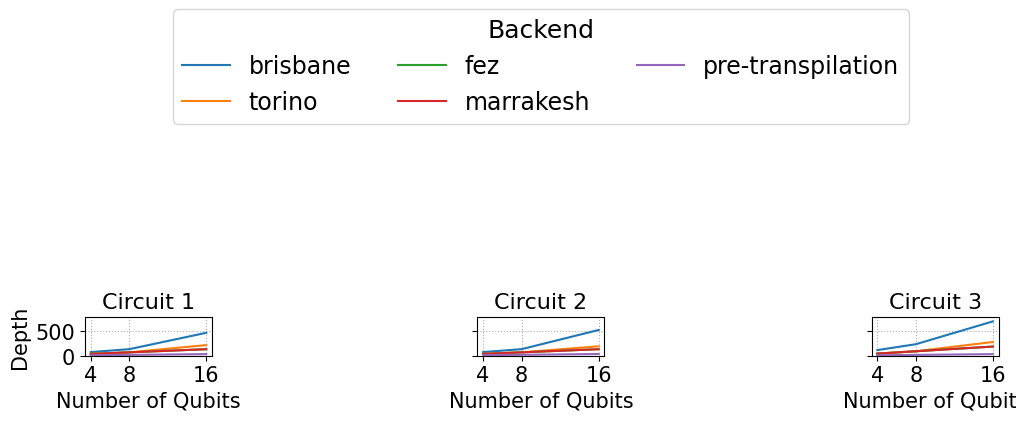

In [130]:
from investigation_functions import ml_visualisation_funcs as mvf
df_all_leg = df_all
df_all_leg['backend']=df_all_leg['backend'].str.replace('fake_', '')
axs =make_line_plots(
    df_all_leg,
    y = 'depth',
    fig_size_=(10,2.5), 
    y_lim=(0,800),
    share_y=True,
    y_label="Depth",
    hue = 'backend',
    col ='circuit',
    col_titles=['Circuit 1','Circuit 2','Circuit 3'],
    # legend_labels=['brisbane','torino','fez','marrakesh','pre-transpiled circuits'],
    legend_title='Backend',
    legend_fontsize=17
    # grid=False
    )

### Total Error per backend

In [48]:
#meta df for summaries files....
summ_dirr = '../'
df_mo = mdf.blank_meta_df()
mdf.load_meta_df(
    df_mo,'Hardware',summ_dirr,updated_results=True,
    summarised = True)

In [13]:
df_mo.head(15).tail(10)

,nr_qubits,backend,sim,circuit_type,file_path
5,4,torino,False,3,../Hardware_results/4q/4q_ibm_torino3_summaris...
6,4,fez,False,1,../Hardware_results/4q/4q_ibm_fez1_summarised.csv
7,4,fez,False,2,../Hardware_results/4q/4q_ibm_fez2_summarised.csv
8,4,fez,False,3,../Hardware_results/4q/4q_ibm_fez3_summarised.csv
9,4,marrakesh,False,1,../Hardware_results/4q/4q_ibm_marrakesh1_summa...
10,4,marrakesh,False,2,../Hardware_results/4q/4q_ibm_marrakesh2_summa...
11,4,marrakesh,False,3,../Hardware_results/4q/4q_ibm_marrakesh3_summa...
12,8,brisbane,False,1,../Hardware_results/8q/8q_ibm_brisbane1_summar...
13,8,brisbane,False,2,../Hardware_results/8q/8q_ibm_brisbane2_summar...
14,8,brisbane,False,3,../Hardware_results/8q/8q_ibm_brisbane3_summar...


In [14]:
df_mo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   nr_qubits     36 non-null     object
 1   backend       36 non-null     object
 2   sim           36 non-null     bool  
 3   circuit_type  36 non-null     object
 4   file_path     36 non-null     object
dtypes: bool(1), object(4)
memory usage: 1.4+ KB


In [49]:
import numpy as np
def get_tot_err(file_path):
    # print(row)
    df = pd.read_csv(file_path)
    # nr_qubits = n_q
    # col_name_0th = str(np.strings.multiply('0',nr_qubits))
    tot_err = df.loc[0,'mean']
    return tot_err

def add_tot_err_col(df):
    df_ = df
    for i in range(len(df_)):
        # nq = int(df_.loc[i,'nr_qubits'])
        file_path = df_.loc[i,'file_path']
        df_.loc[i,'tot_err']=get_tot_err(file_path)
    return df_
    

In [50]:
df_m = add_tot_err_col(df_mo)
df_m.head()

,nr_qubits,backend,sim,circuit_type,file_path,tot_err
0,4,brisbane,False,1,../Hardware_results/4q/4q_ibm_brisbane1_summar...,732.719298
1,4,brisbane,False,2,../Hardware_results/4q/4q_ibm_brisbane2_summar...,734.771930
2,4,brisbane,False,3,../Hardware_results/4q/4q_ibm_brisbane3_summar...,905.719298
3,4,torino,False,1,../Hardware_results/4q/4q_ibm_torino1_summaris...,762.473684
4,4,torino,False,2,../Hardware_results/4q/4q_ibm_torino2_summaris...,742.578947


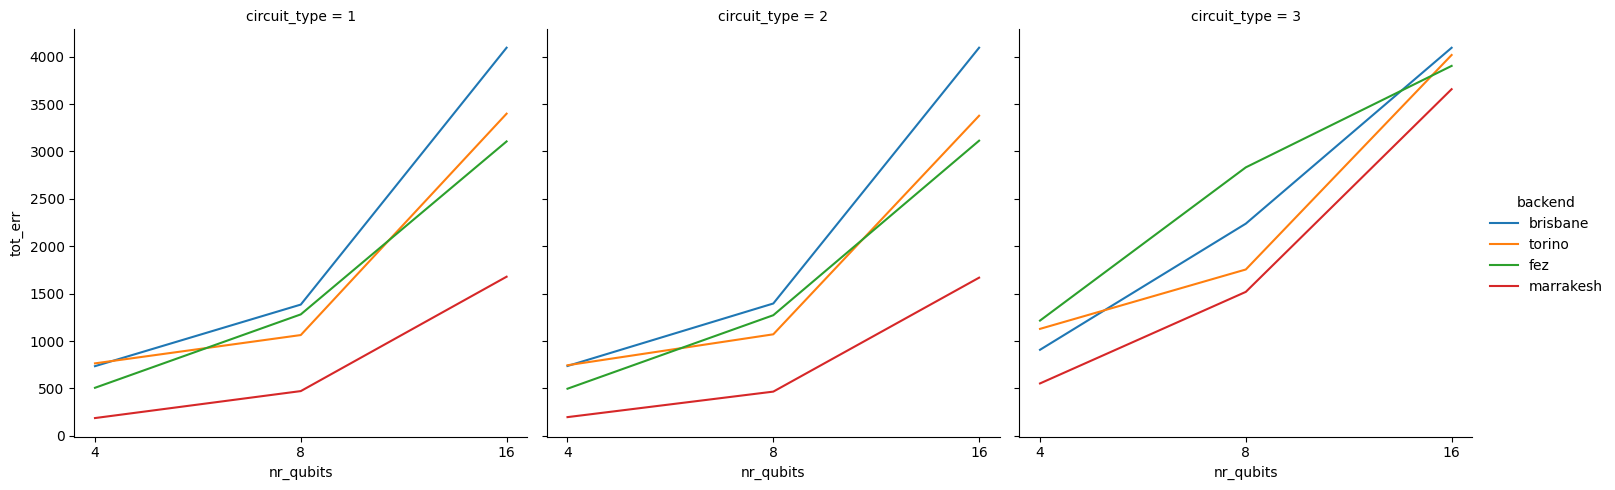

In [58]:
sns.relplot(
    data=df_m,
    x='nr_qubits', 
    y='tot_err', 
    hue='backend', 
    kind='line',
    col = 'circuit_type'
)

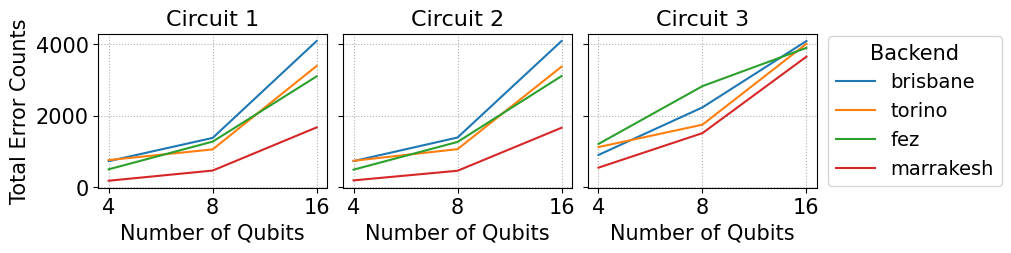

In [64]:
axs =make_line_plots(
    df_m,
    x='nr_qubits',
    y = 'tot_err',
    fig_size_=(10,2.5), 
    y_lim=None,
    # share_y=False,
    y_label="Total Error Counts",
    hue = 'backend',
    col ='circuit_type',
    col_titles=['Circuit 1','Circuit 2','Circuit 3'],
    # legend_labels=['brisbane','torino','fez','marrakesh','pre-transpiled circuits'],
    legend_title='Backend',
    # legend_fontsize=14
    # grid=False
    )

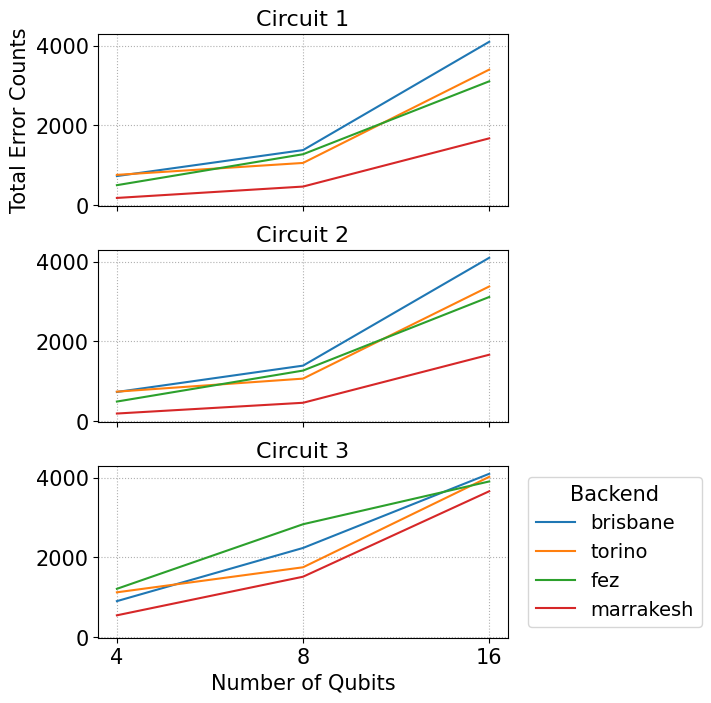

In [99]:
axs =make_line_plots(
    df_m,
    x='nr_qubits',
    y = 'tot_err',
    fig_size_=(7,7), 
    y_lim=None,
    # share_y=False,
    y_label="Total Error Counts",
    hue = 'backend',
    col ='circuit_type',
    col_titles=['Circuit 1','Circuit 2','Circuit 3'],
    # legend_labels=['brisbane','torino','fez','marrakesh','pre-transpiled circuits'],
    legend_title='Backend',
    vertical_stack=True,
    x_ticks_auto=True
    # legend_fontsize=14
    # grid=False
    )

In [18]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nr_qubits     36 non-null     object 
 1   backend       36 non-null     object 
 2   sim           36 non-null     bool   
 3   circuit_type  36 non-null     object 
 4   file_path     36 non-null     object 
 5   tot_err       36 non-null     float64
dtypes: bool(1), float64(1), object(4)
memory usage: 2.8+ KB


In [46]:
dirr_transpiled = dirr
df_4qtranspiled_met = pd.read_csv(dirr_transpiled+'transpiled_metrics_4qubits.csv')
df_8qtranspiled_met = pd.read_csv(dirr_transpiled+'transpiled_metrics_8qubits.csv')
df_16qtranspiled_met = pd.read_csv(dirr_transpiled+'transpiled_metrics_16qubits.csv')
transpiled_dfs = [df_4qtranspiled_met,df_8qtranspiled_met,df_16qtranspiled_met]

transp_all =pd.concat(transpiled_dfs, ignore_index=True)

In [47]:
transp_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   nr_qubits  45 non-null     int64 
 1   backend    45 non-null     object
 2   circuit    45 non-null     int64 
 3   depth      45 non-null     int64 
 4   size       45 non-null     int64 
 5   width      45 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 2.2+ KB


In [48]:
no_preT= transp_all[transp_all['backend']!='pre-transpilation']
no_preT.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 0 to 41
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   nr_qubits  36 non-null     int64 
 1   backend    36 non-null     object
 2   circuit    36 non-null     int64 
 3   depth      36 non-null     int64 
 4   size       36 non-null     int64 
 5   width      36 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 2.0+ KB


In [61]:
no_preT['backend'].unique()

array(['fake_brisbane', 'fake_torino', 'fake_fez', 'fake_marrakesh'],
      dtype=object)

In [99]:
total = pd.concat(
    [no_preT.reset_index(drop=True),
    df_m['tot_err']],
    axis=1,
    join = 'inner'
)
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nr_qubits  36 non-null     int64  
 1   backend    36 non-null     object 
 2   circuit    36 non-null     int64  
 3   depth      36 non-null     int64  
 4   size       36 non-null     int64  
 5   width      36 non-null     int64  
 6   tot_err    36 non-null     float64
dtypes: float64(1), int64(5), object(1)
memory usage: 2.1+ KB


In [100]:
total.head(40)

,nr_qubits,backend,circuit,depth,size,width,tot_err
0,4,fake_brisbane,1,74,148,131,732.719298
1,4,fake_brisbane,2,74,154,131,734.771930
2,4,fake_brisbane,3,115,226,131,905.719298
3,4,fake_torino,1,37,70,137,762.473684
4,4,fake_torino,2,37,76,137,742.578947
5,4,fake_torino,3,43,82,137,1126.561404
6,4,fake_fez,1,37,70,160,504.500000
7,4,fake_fez,2,37,76,160,494.780000
8,4,fake_fez,3,43,82,160,1214.000000
9,4,fake_marrakesh,1,37,70,160,184.940000


### Plotting err per backend vs depth

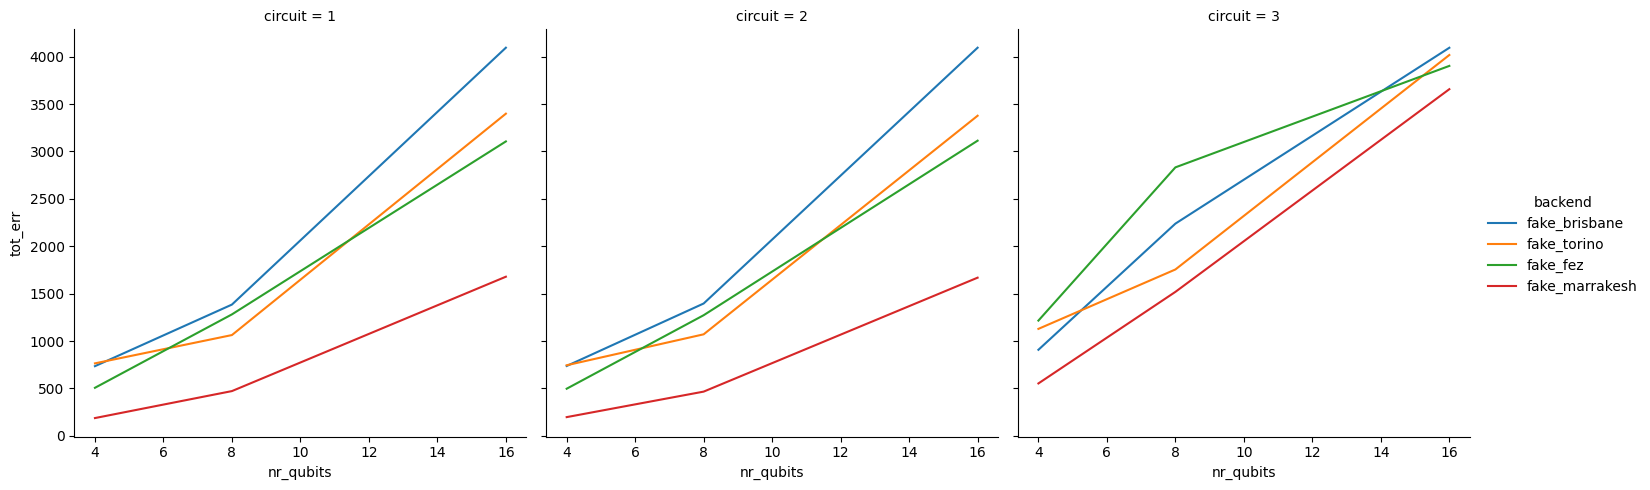

In [102]:
sns.relplot(
    data=total,
    x='nr_qubits', 
    y='tot_err', 
    hue='backend', 
    kind='line',
    col = 'circuit'
)

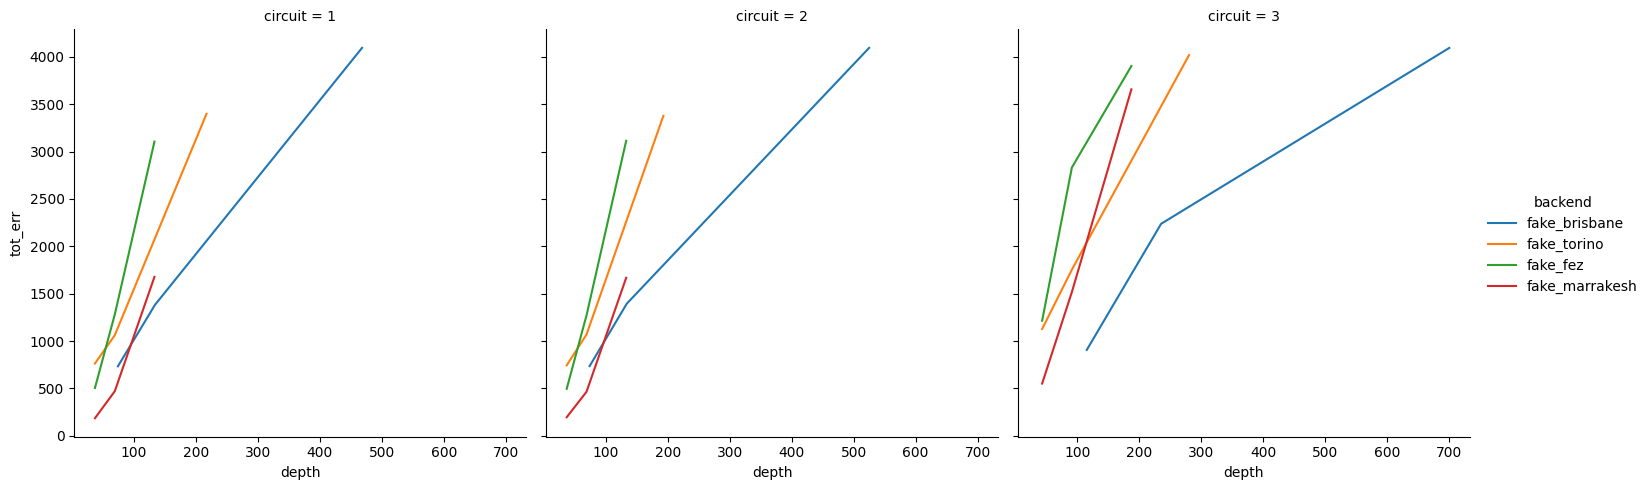

In [103]:
sns.relplot(
    data=total,
    x='depth', 
    y='tot_err', 
    hue='backend', 
    kind='line',
    col = 'circuit'
)

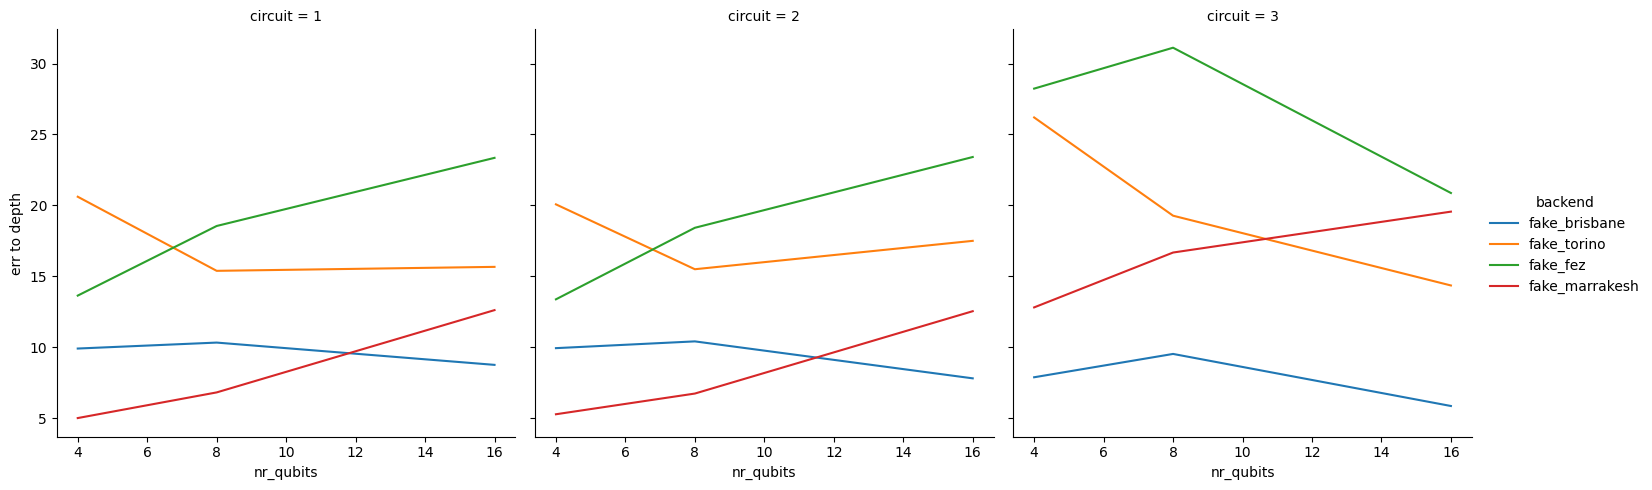

In [104]:
df_err_2_depth = total
df_err_2_depth['err to depth'] = df_err_2_depth['tot_err'] / df_err_2_depth['depth']
sns.relplot(
    data=df_err_2_depth,
    x='nr_qubits', 
    y='err to depth', 
    hue='backend', 
    kind='line',
    col = 'circuit'
)